# May ??th, 2022 (Ent GABAN, 512 * 3)

**Motivation**: Make ent plots (KABA) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def quick_show(data, vmin=0.1, vmax=None, figsize=None, cmap='magma'):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (12.8, 1.25 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=True,
        reshape=True,
    )
 
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=13)
    remove_ticks(axes)
    plt.show()

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice(512)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

## task = 'rest', k = 6, p = 10

In [5]:
task = 'rest'

num_k, p = 6, 10
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [6]:
d2p = {}
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
gr_bo.avg()
d2p['bold+1'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 95 + mg1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3))
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)
d2p['bold\npr95+mg'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 99 + mg1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.99)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)
d2p['bold\npr99+mg'] = gr_bo.trim2d(gr_bo.project_vec())

pi_ca = {}
for b in [0.5, (0.01, 0.50)]:
    mice.setup_func_data(task, band_ca=b)
    gr_ca = Group(**props_ca).fit_group()
    gr_ca.avg()
    
    pr_ca = gr_ca.prune(n_resamples=int(7e3))
    gr_ca.run_pi = pr_ca['pi_prune_run']
    gr_ca.pi = pr_ca['pi_prune_avg']

    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())
    pi_ca[b] = gr_ca.pi

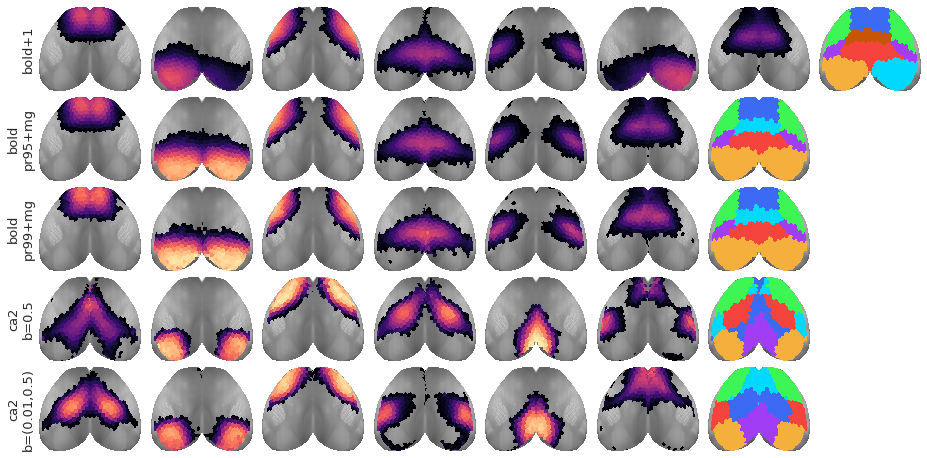

In [7]:
quick_show(d2p, vmin=0.1, vmax=1.0)

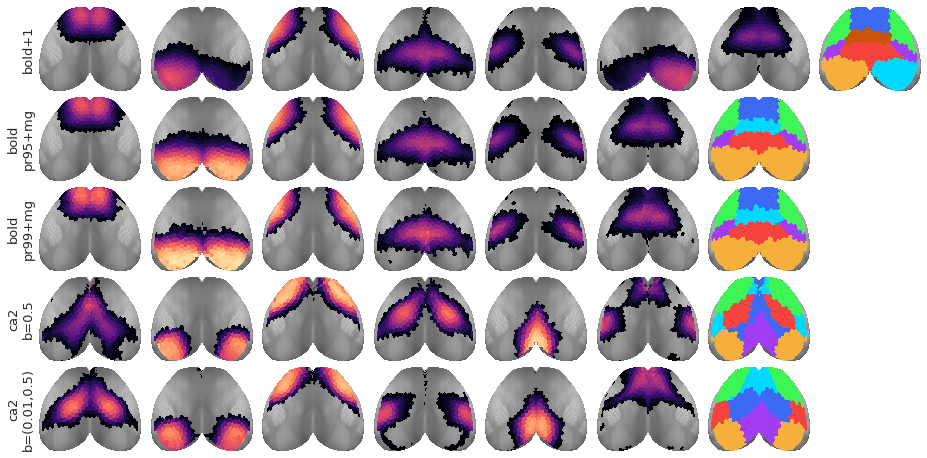

## results k = 6

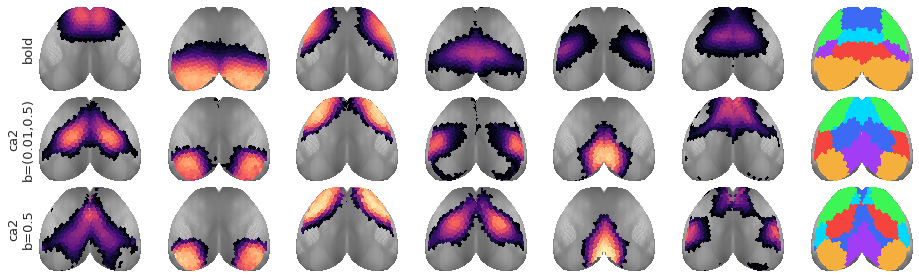

In [8]:
_x = {'bold': d2p['bold\npr95+mg'], **dict(sorted({k: v for k, v in d2p.items() if 'ca2' in k}.items()))}
quick_show(_x, vmin=0.1, vmax=1.0)

In [9]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
h_ca = sp_stats.entropy(pr_ca['pi_prune_run'], axis=-2) / np.log(gr_ca.num_k)
h_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 2), 1), 0)

In [10]:
b = 0.5
mice.setup_func_data(task, band_ca=b)
gr_ca2 = Group(**props_ca).fit_group()
gr_ca2.avg()

pr_ca2 = gr_ca2.prune(n_resamples=int(7e3))
h_ca2 = sp_stats.entropy(pr_ca2['pi_prune_run'], axis=-2) / np.log(gr_ca2.num_k)
h_avg_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca2, 2), 1), 0)

In [11]:
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)

h_bo = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo = bn.nanmean(bn.nanmean(bn.nanmean(h_bo, 2), 1), 0)

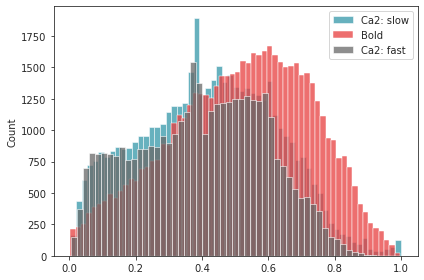

In [12]:
fig, ax = create_figure()
sns.histplot(h_ca[h_ca.nonzero()], color=pal['ca2'], label='Ca2: slow', ax=ax)
sns.histplot(h_bo[h_bo.nonzero()], color=pal['bold-lite'], label='Bold', ax=ax)
sns.histplot(h_ca2[h_ca2.nonzero()], color='dimgrey', label='Ca2: fast', ax=ax)
ax.legend()
plt.show()

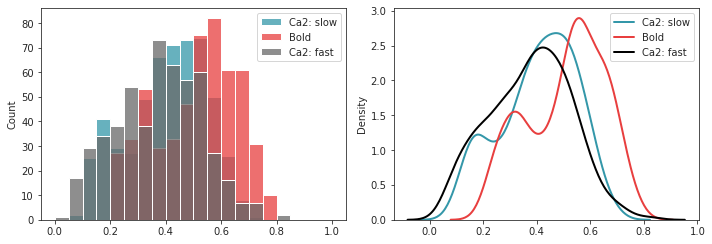

In [13]:
fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 1, 21),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 1, 21),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 1, 21),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()

In [14]:
hr_ca = sp_stats.rankdata(h_ca, axis=-1)
hr_ca2 = sp_stats.rankdata(h_ca2, axis=-1)
hr_bo = sp_stats.rankdata(h_bo, axis=-1)

hr_ca[np.isnan(h_ca)] = np.nan
hr_ca2[np.isnan(h_ca2)] = np.nan
hr_bo[np.isnan(h_bo)] = np.nan

hr_ca = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca, 2), 1), 0)
hr_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca2, 2), 1), 0)
hr_bo = bn.nanmean(bn.nanmean(bn.nanmean(hr_bo, 2), 1), 0)

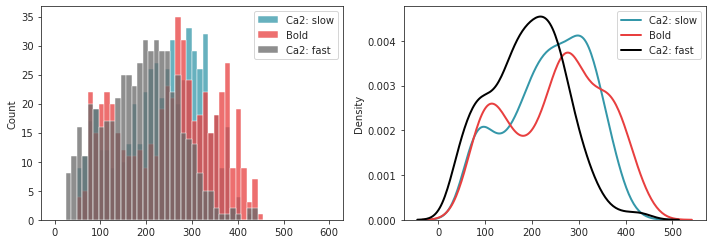

In [15]:
fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 600, 51),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 600, 51),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    hr_ca2[hr_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 600, 51),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_ca2[hr_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()

In [16]:
trh_ca2 = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca2, add_disjoint=False))
trh_ca = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca, add_disjoint=False))
trh_bo = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca2), np.nanmin(h_avg_ca), np.nanmin(h_avg_bo))
vmax = max(np.nanmax(h_avg_ca2), np.nanmax(h_avg_ca), np.nanmax(h_avg_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.04733664136637236, 0.8225938492229676)

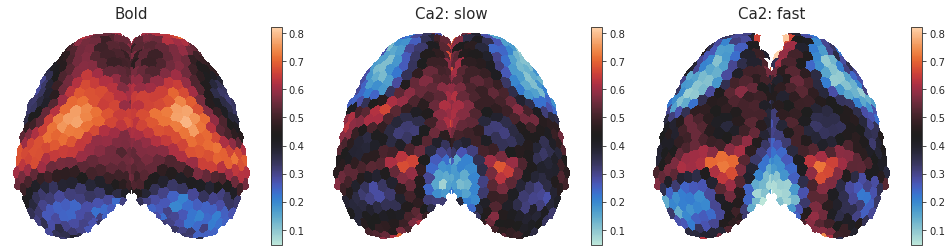

In [17]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_ca2['proj-top'][0] < vmin, trh_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [18]:
trhr_ca2 = gr_ca.trim2d(gr_ca.project_vec(hr_ca2, add_disjoint=False))
trhr_ca = gr_ca.trim2d(gr_ca.project_vec(hr_ca, add_disjoint=False))
trhr_bo = gr_ca.trim2d(gr_bo.project_vec(hr_bo, add_disjoint=False))

vmin = min(np.nanmin(hr_ca2), np.nanmin(hr_ca), np.nanmin(hr_bo))
vmax = max(np.nanmax(hr_ca2), np.nanmax(hr_ca), np.nanmax(hr_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(24.85648148148148, 453.575)

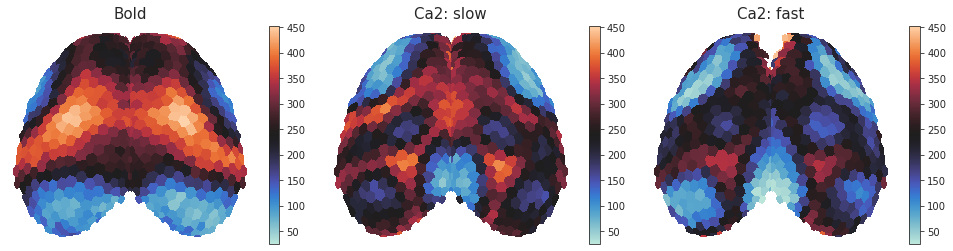

In [19]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trhr_bo['proj-top'][0] < vmin, trhr_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trhr_ca['proj-top'][0] < vmin, trhr_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trhr_ca2['proj-top'][0] < vmin, trhr_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

<AxesSubplot:ylabel='Count'>

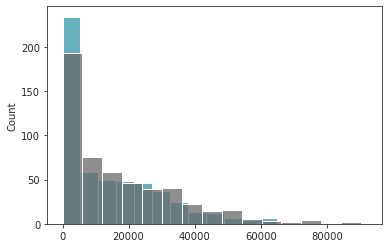

In [20]:
delta_ca = (hr_bo - hr_ca) ** 2
delta_ca2 = (hr_bo - hr_ca2) ** 2

sns.histplot(delta_ca, color=pal['ca2'])
sns.histplot(delta_ca2, color='dimgrey')

In [21]:
tr_delta = gr_ca.trim2d(gr_ca.project_vec(delta_ca, add_disjoint=False))
tr_delta2 = gr_ca.trim2d(gr_ca.project_vec(delta_ca2, add_disjoint=False))

vmin = min(np.nanmin(delta_ca), np.nanmin(delta_ca2))
vmax = max(np.nanmax(delta_ca), np.nanmax(delta_ca2))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'hot',
}
vmin, vmax

(0.0010204475308644599, 92040.13603347432)

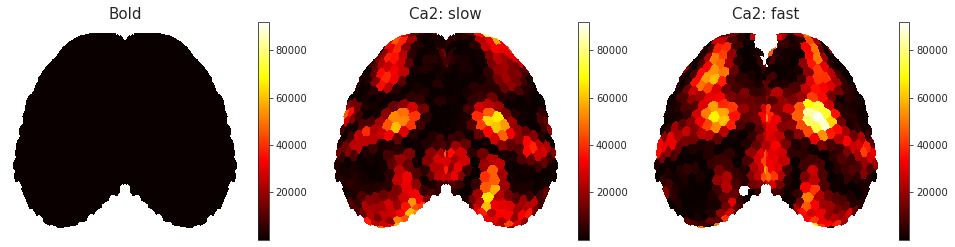

In [22]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(tr_delta['proj-top'][0] < vmin, tr_delta['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(tr_delta2['proj-top'][0] < vmin, tr_delta2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

## True comparison

In [7]:
task = 'rest'

num_k, p = 6, 10
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}


d2p = {}
gr_bo = Group(**props_bo).fit_group()
gr_bo.avg()
d2p['bold'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 95
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3))
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
d2p['bold\npr95'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 99
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.99)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
d2p['bold\npr99'] = gr_bo.trim2d(gr_bo.project_vec())

pi_ca = {}
for b in [0.5, (0.01, 0.50)]:
    mice.setup_func_data(task, band_ca=b)
    gr_ca = Group(**props_ca).fit_group()
    gr_ca.avg()
    
    pr_ca = gr_ca.prune(n_resamples=int(7e3))
    gr_ca.run_pi = pr_ca['pi_prune_run']
    gr_ca.pi = pr_ca['pi_prune_avg']

    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())
    pi_ca[b] = gr_ca.pi

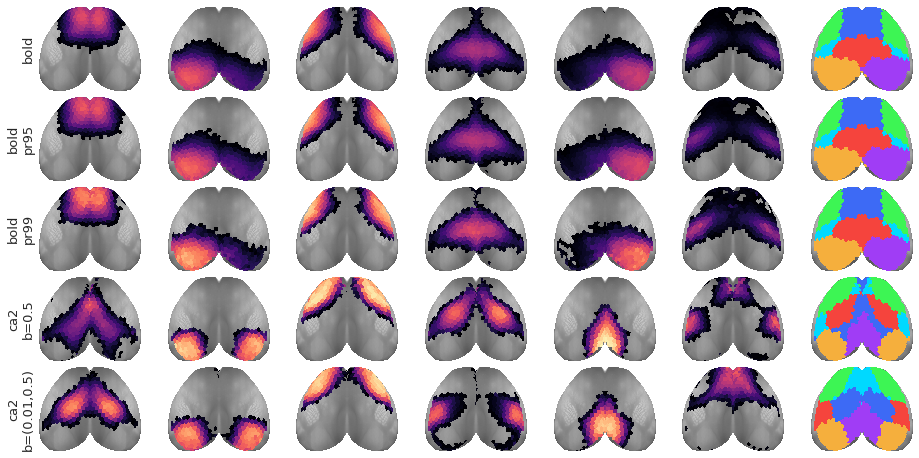

In [8]:
quick_show(d2p, vmin=0.1, vmax=1.0)

In [9]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
h_ca = sp_stats.entropy(pr_ca['pi_prune_run'], axis=-2) / np.log(gr_ca.num_k)
h_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 2), 1), 0)


b = 0.5
mice.setup_func_data(task, band_ca=b)
gr_ca2 = Group(**props_ca).fit_group()
gr_ca2.avg()

pr_ca2 = gr_ca2.prune(n_resamples=int(7e3))
h_ca2 = sp_stats.entropy(pr_ca2['pi_prune_run'], axis=-2) / np.log(gr_ca2.num_k)
h_avg_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca2, 2), 1), 0)

gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)

h_bo = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo = bn.nanmean(bn.nanmean(bn.nanmean(h_bo, 2), 1), 0)

In [10]:
hr_ca = sp_stats.rankdata(h_ca, axis=-1)
hr_ca2 = sp_stats.rankdata(h_ca2, axis=-1)
hr_bo = sp_stats.rankdata(h_bo, axis=-1)

hr_ca[np.isnan(h_ca)] = np.nan
hr_ca2[np.isnan(h_ca2)] = np.nan
hr_bo[np.isnan(h_bo)] = np.nan

hr_ca = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca, 2), 1), 0)
hr_ca2 = bn.nanmean(bn.nanmean(bn.nanmean(hr_ca2, 2), 1), 0)
hr_bo = bn.nanmean(bn.nanmean(bn.nanmean(hr_bo, 2), 1), 0)

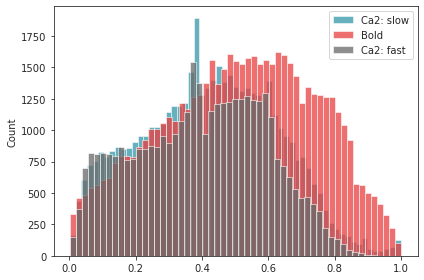

In [11]:
fig, ax = create_figure()
sns.histplot(h_ca[h_ca.nonzero()], color=pal['ca2'], label='Ca2: slow', ax=ax)
sns.histplot(h_bo[h_bo.nonzero()], color=pal['bold-lite'], label='Bold', ax=ax)
sns.histplot(h_ca2[h_ca2.nonzero()], color='dimgrey', label='Ca2: fast', ax=ax)
ax.legend()
plt.show()

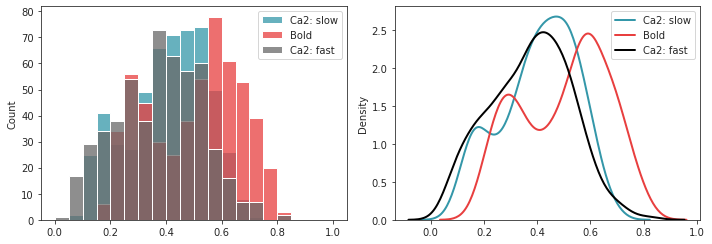

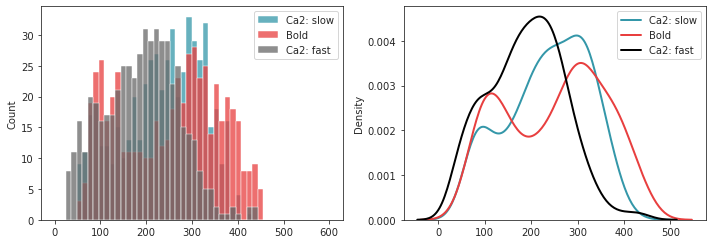

In [13]:
fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 1, 21),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 1, 21),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 1, 21),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    h_avg_ca[h_avg_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_bo[h_avg_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    h_avg_ca2[h_avg_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()



fig, axes = create_figure(1, 2, (10, 3.5))

sns.histplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    bins=np.linspace(0, 600, 51),
    label='Ca2: slow',
    ax=axes[0],
)
sns.histplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    bins=np.linspace(0, 600, 51),
    label='Bold',
    ax=axes[0],
)
sns.histplot(
    hr_ca2[hr_ca2.nonzero()],
    color='dimgrey',
    bins=np.linspace(0, 600, 51),
    label='Ca2: fast',
    ax=axes[0],
)
axes[0].legend()

sns.kdeplot(
    hr_ca[hr_ca.nonzero()],
    color=pal['ca2'],
    label='Ca2: slow',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_bo[hr_bo.nonzero()],
    color=pal['bold-lite'],
    label='Bold',
    lw=2,
    ax=axes[1],
)
sns.kdeplot(
    hr_ca2[hr_ca2.nonzero()],
    color='k',
    label='Ca2: fast',
    lw=2,
    ax=axes[1],
)
axes[1].legend()

plt.show()

In [32]:
trh_ca2 = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca2, add_disjoint=False))
trh_ca = gr_ca.trim2d(gr_ca.project_vec(h_avg_ca, add_disjoint=False))
trh_bo = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca2), np.nanmin(h_avg_ca), np.nanmin(h_avg_bo))
vmax = max(np.nanmax(h_avg_ca2), np.nanmax(h_avg_ca), np.nanmax(h_avg_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.04733664136637236, 0.8225938492229676)

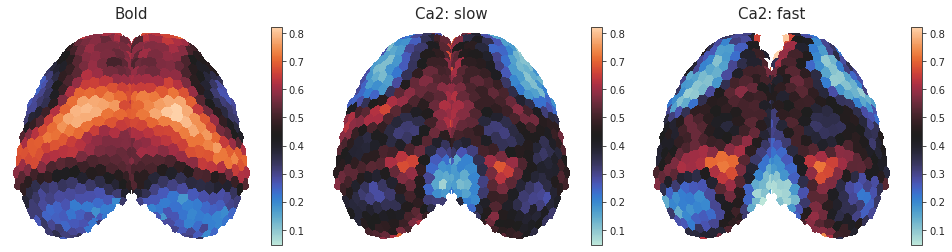

In [33]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_ca2['proj-top'][0] < vmin, trh_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [34]:
trhr_ca2 = gr_ca.trim2d(gr_ca.project_vec(hr_ca2, add_disjoint=False))
trhr_ca = gr_ca.trim2d(gr_ca.project_vec(hr_ca, add_disjoint=False))
trhr_bo = gr_ca.trim2d(gr_bo.project_vec(hr_bo, add_disjoint=False))

vmin = min(np.nanmin(hr_ca2), np.nanmin(hr_ca), np.nanmin(hr_bo))
vmax = max(np.nanmax(hr_ca2), np.nanmax(hr_ca), np.nanmax(hr_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(24.85648148148148, 453.7333333333333)

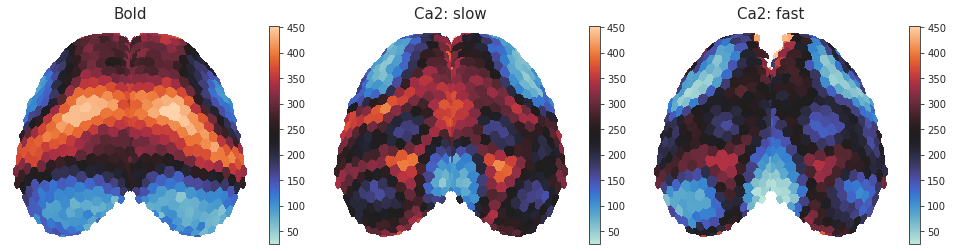

In [35]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trhr_bo['proj-top'][0] < vmin, trhr_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trhr_ca['proj-top'][0] < vmin, trhr_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trhr_ca2['proj-top'][0] < vmin, trhr_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

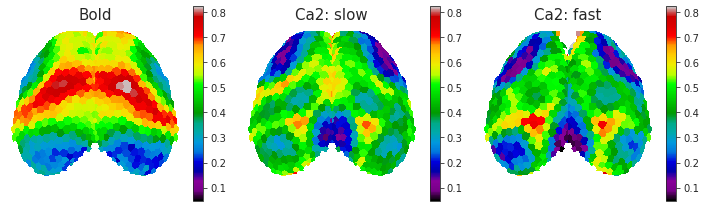

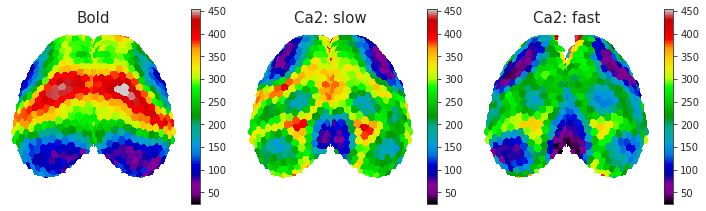

In [38]:
cmap = 'nipy_spectral'

vmin = min(np.nanmin(h_avg_ca2), np.nanmin(h_avg_ca), np.nanmin(h_avg_bo))
vmax = max(np.nanmax(h_avg_ca2), np.nanmax(h_avg_ca), np.nanmax(h_avg_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': cmap,
}

fig, axes = create_figure(1, 3, (10, 3.))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] < vmin, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_ca['proj-top'][0] < vmin, trh_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_ca2['proj-top'][0] < vmin, trh_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()



vmin = min(np.nanmin(hr_ca2), np.nanmin(hr_ca), np.nanmin(hr_bo))
vmax = max(np.nanmax(hr_ca2), np.nanmax(hr_ca), np.nanmax(hr_bo))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': cmap,
}

fig, axes = create_figure(1, 3, (10, 3.))

im = axes[0].imshow(mwh(trhr_bo['proj-top'][0] < vmin, trhr_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trhr_ca['proj-top'][0] < vmin, trhr_ca['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trhr_ca2['proj-top'][0] < vmin, trhr_ca2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

<AxesSubplot:ylabel='Count'>

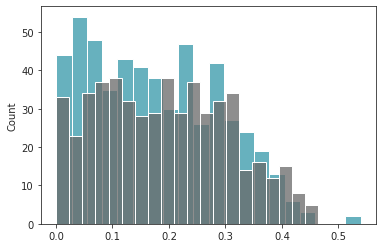

In [47]:
delta_ca = np.abs(h_avg_bo - h_avg_ca)
delta_ca2 = np.abs(h_avg_bo - h_avg_ca2)

sns.histplot(delta_ca, color=pal['ca2'], bins=20)
sns.histplot(delta_ca2, color='dimgrey', bins=20)

<AxesSubplot:ylabel='Count'>

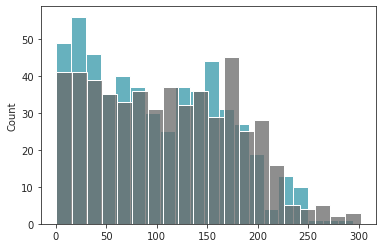

In [41]:
delta_ca = np.abs(hr_bo - hr_ca)
delta_ca2 = np.abs(hr_bo - hr_ca2)

sns.histplot(delta_ca, color=pal['ca2'], bins=20)
sns.histplot(delta_ca2, color='dimgrey', bins=20)

In [42]:
bn.nanmean(delta_ca), bn.nanmean(delta_ca2)

(99.52809514962705, 110.2992321782654)

In [43]:
tr_delta = gr_ca.trim2d(gr_ca.project_vec(delta_ca, add_disjoint=False))
tr_delta2 = gr_ca.trim2d(gr_ca.project_vec(delta_ca2, add_disjoint=False))

vmin = min(np.nanmin(delta_ca), np.nanmin(delta_ca2))
vmax = max(np.nanmax(delta_ca), np.nanmax(delta_ca2))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'hot',
}
vmin, vmax

(0.2888888888888772, 302.00277777777774)

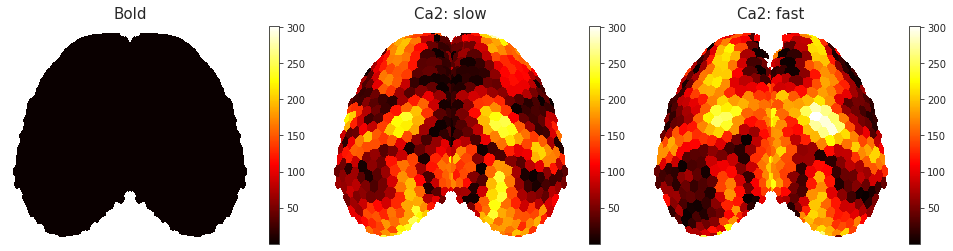

In [45]:
fig, axes = create_figure(1, 3, (13.5, 3.4))

im = axes[0].imshow(mwh(trh_bo['proj-top'][0] == 0, trh_bo['proj-top'][0]), **kw_im)
axes[0].set_title('Bold', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(tr_delta['proj-top'][0] < vmin, tr_delta['proj-top'][0]), **kw_im)
axes[1].set_title('Ca2: slow', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(tr_delta2['proj-top'][0] < vmin, tr_delta2['proj-top'][0]), **kw_im)
axes[2].set_title('Ca2: fast', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()